# Necessary Imports and Installs

In [103]:
import sklearn as sk
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from freegs import machine
from freegs.equilibrium import Equilibrium
from freegs.coil import Coil
from freegs.machine import Circuit
from freegs.gradshafranov import GSsparse
from freegs.gradshafranov import Greens
from freegs.jtor import ConstrainPaxisIp
from freegs import control
from freegs import picard


# Playground For Testing

## FreeGS 

### Tokamak Coils

#### Toroidal currents

The magnetic field due to a toroidal wire is calculated using Green's functions
https://github.com/freegs-plasma/freegs/blob/master/freegs/gradshafranov.py#L272

These are written in terms of elliptic functions of the first and second kind

**Note** Some care is needed because there are different definitions (e.g. if arg is squared)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipk.html
https://mathworld.wolfram.com/EllipticIntegraloftheFirstKind.html

First kind:
$K(m) = \int_0^{\pi/2}\frac{1}{\sqrt{1 - m \sin^2\left(t\right)}}dt$

Second kind:
$E(m) = \int_0^{\pi/2}\sqrt{1 - m \sin^2\left(t\right)}dt$

Poloidal flux at $(R, Z)$ due to unit current at $(R_c, Z_c)$ is the current in the coil $I_c$ times the Green's function:

$\psi\left(R, Z; R_c, Z_c\right) = I_c G\left(R, Z; R_c, Z_c\right)$

with Green's function given by:
$G\left(R, Z; R_c, Z_c\right) = \frac{\mu_0}{2\pi} \sqrt{RR_c}\left[(2 - k^2)K\left(k^2\right) - 2E\left(k^2\right)\right] / k$
where
$k^2 = 4RR_c / \left[\left(R + R_c\right)^2 + \left(Z - Z_c\right)^2\right]$

Text(0, 0.5, 'Height Z [m]')

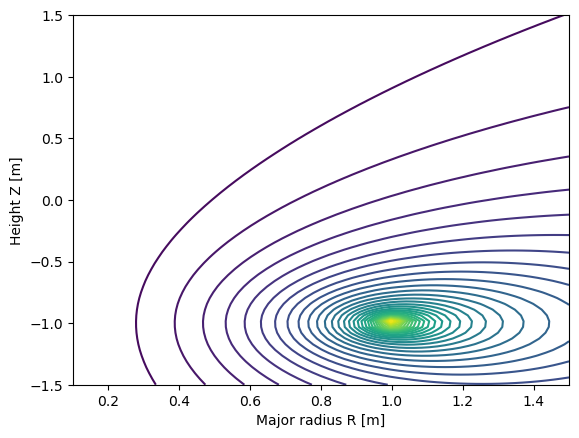

In [98]:
from freegs.coil import Coil


coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA

# Make a 2D grid of R, Z values
# Note: Number of cells 65 = 2^n + 1 is useful later
R, Z = np.meshgrid(np.linspace(0.1, 1.5, 65), np.linspace(-1.5, 1.5, 65), indexing='ij')

# Calculate poloidal flux psi due to coil:
psi = coil_1.psi(R, Z)

plt.contour(R, Z, psi, 40)
plt.xlabel("Major radius R [m]")
plt.ylabel("Height Z [m]")

It can be (initially) easier to visualise what the magnetic field looks like rather than the flux

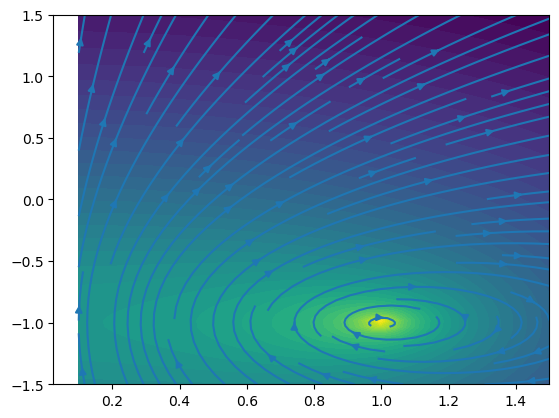

In [28]:
# Radial component of the magnetic field
B_R = coil_1.Br(R, Z)
# Vertical component
B_Z = coil_1.Bz(R, Z)

# Poloidal field magnitude
B_p = np.sqrt(B_R**2 + B_Z**2)

plt.contourf(R, Z, np.log(B_p), 50)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

#### Vertical magnetic field

Combining two coils with current in the same direction produces a vertical magnetic field
(A Helmholtz coil)

This is used for **radial** plasma position control

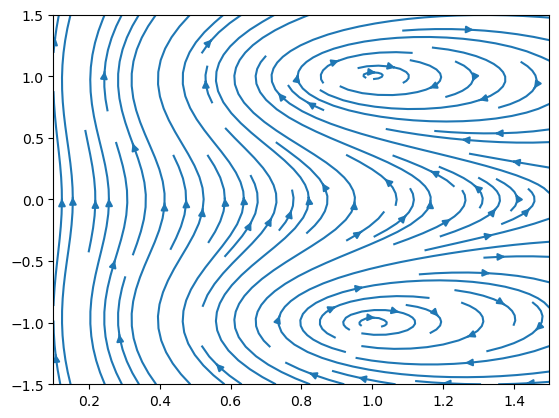

In [29]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = 1e3)  # R = 1m, Z = +1m, current = 1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

#### Radial magnetic field

Coils with opposite currents produces a radial magnetic field.

This is used for **vertical** plasma position control

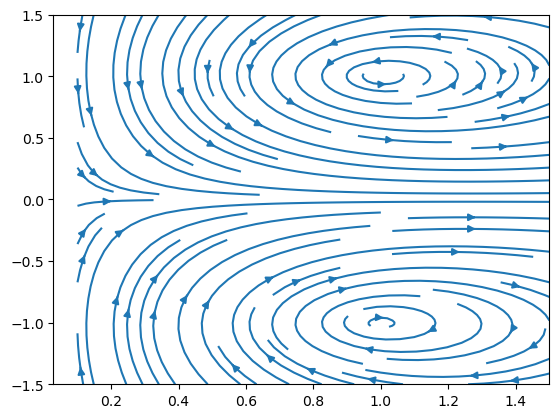

In [30]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = -1e3)  # R = 1m, Z = +1m, current = -1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

#### Circuits

Most tokamaks do not have a separate power supply for each coil. Instead they are often wired in pairs, either in series or anti-series.

FreeGS defines a `Circuit` class to group coils together

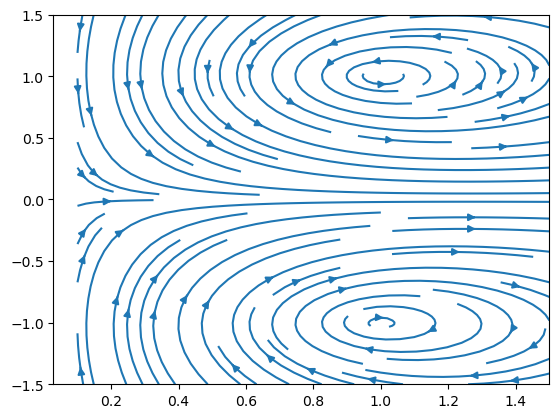

In [31]:
from freegs.machine import Circuit

circuit_1 = Circuit([("P1L", Coil(1.0, -1.0), 1.0),
                    ("P1U", Coil(1.0, 1.0), -1.0)], # Negative so anti-series
                   current = 1e3) # 1kA in this circuit
B_R = circuit_1.Br(R, Z)
B_Z = circuit_1.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

### Plasma Control

#### Change of topic: Plasma current

The plasma carries a current in the toroidal and poloidal direction. The toroidal plasma current generates a poloidal magnetic field that adds to the field from the poloidal field (PF) coils.

The principle is the same as for the coils, except we're integrating a current density over the plasma: The poloidal flux at $(R, Z)$ is 

$\psi_{plasma}\left(R, Z\right) = \int_{R,Z}J_\phi\left(R', Z'\right) G\left(R, Z; R', Z'\right) dR'dZ'$

where $J_\phi\left(R, Z\right)$ is the toroidal current density (in A/m$^2$) in the plasma.

#### Computationally efficient methods

Unfortunately the brute-force way to calculate $\psi_{plasma}\left(R, Z\right)$ using the above integral is very slow. For an $N\times N$ mesh the time to calculate a $\psi$ at every point goes like $N^4$.
(Note that techniques like fast multipole can improve this, but would be quite complex to implement).

Instead we start from the differential form and solve a Laplacian-like equation for $\psi$

$\Delta^*\psi = R^2 \nabla\cdot\frac{1}{R^2}\nabla\psi = -\mu_0 R J_\phi$

Multi-grid solvers can be very effective for this kind of problem, with run-time scaling linear with the number of unknowns. 
**Note** Simpler but theoretically worse scaling methods can be faster for small mesh sizes $N$.

To do this we need to:
- Generate a matrix that represents the $\Delta^*$ operator on each mesh resolution: https://github.com/freegs-plasma/freegs/blob/master/freegs/gradshafranov.py#L153
- If using multiple resolution levels, generate a matrix for each level: https://github.com/freegs-plasma/freegs/blob/master/freegs/multigrid.py#L139
- At the coarsest level create a direct solver (using LU decomposition in SciPy): https://github.com/freegs-plasma/freegs/blob/master/freegs/multigrid.py#L35

In [32]:
# Define a toroidal current density
J_tor = np.exp(-(R - 0.5)**2 - Z**2) * 1e3  # In A/m^2

# Matrix generator, giving range of R and Z we're going to solve over
from freegs.gradshafranov import GSsparse
generator = GSsparse(np.amin(R), np.amax(R), np.amin(Z), np.amax(Z))

# For example a 3x3 mesh. 2nd order method has 5-point stencil
np.set_printoptions(precision=2)
generator(3,3).toarray()

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  2.93,  0.  ,  0.44, -4.97,  0.44,  0.  ,  1.15,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

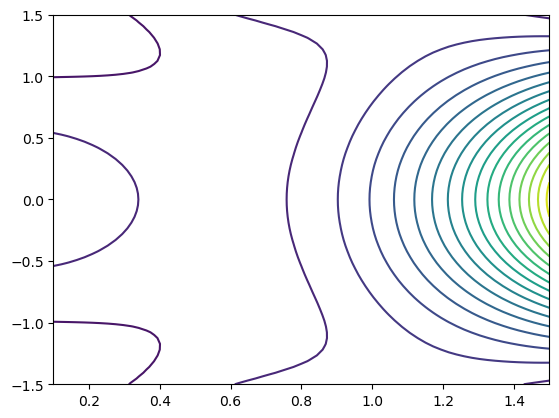

In [33]:
# Generate a matrix for our array
nx, ny = R.shape
A = generator(nx, ny)

# LU factorize (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.factorized.html)
from scipy.sparse.linalg import factorized
solver = factorized(A.tocsc())

# Solve for psi from J_tor
mu0 = 4e-7 * np.pi
psi = solver((mu0 * R * J_tor).flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

The boundaries look wrong (they *are* wrong): In the 3x3 matrix above the boundary cells have `1` on the diagonal. That means the boundary values of $\psi$ are set to the boundary cells of the RHS, i.e. $\mu_0 R J_\phi$.

One approximation is to set boundaries to conducting: $\psi = $ constant on the boundary

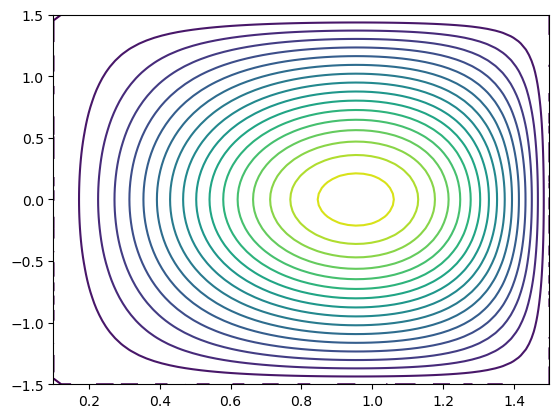

In [34]:
rhs = -mu0 * R * J_tor
# Set all boundaries of psi to zero:
rhs[0,:] = rhs[-1,:] = rhs[:,0] = rhs[:,-1] = 0

# Re-solve
psi = solver(rhs.flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

#### Free boundary solutions

To obtain the boundary conditions for a "free" boundary, one way is to use the brute-force approach (integrate Green's functions) along the boundary.
https://github.com/freegs-plasma/freegs/blob/master/freegs/boundary.py#L50

For each point on the boundary we perform an integral over the 2D $(R,Z)$ domain.

Romberg integration is an accurate method, but needs $2^n + 1$ points. Hence grid sizes like 33, 65, 129.

Note: 
- This is more efficient than a full brute force, because integrals are only for the boundary points rather than every point in the domain
- A more effient method is von Hagenow's method. That replaces 2D integrals with a calculation of normal derivatives, and a 1D integral over the boundary. The default method in FreeGS: https://github.com/freegs-plasma/freegs/blob/master/freegs/boundary.py#L102

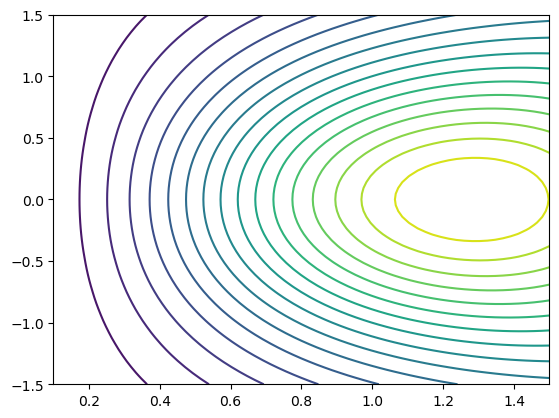

In [35]:
rhs = -mu0 * R * J_tor

# List of indices on the boundary
bndry_indices = np.concatenate(
    [
        [(x, 0) for x in range(nx)],
        [(x, ny - 1) for x in range(nx)],
        [(0, y) for y in range(ny)],
        [(nx - 1, y) for y in range(ny)],
    ]
)

from freegs.gradshafranov import Greens
from scipy.integrate import romb

dR = R[1, 0] - R[0, 0]
dZ = Z[0, 1] - Z[0, 0]

for x, y in bndry_indices:
    # Calculate the response of the boundary point
    # to each cell in the plasma domain
    greenfunc = Greens(R, Z, R[x, y], Z[x, y])

    # Prevent infinity/nan by removing (x,y) point
    greenfunc[x, y] = 0.0
    
    # Integrate over the domain
    rhs[x, y] = romb(romb(greenfunc * J_tor)) * dR * dZ
    
# Re-solve
psi = solver(rhs.flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

#### Radial motion

Plotting the toroidal current $J_\phi$ on top of the contours of $\psi$ we will see that they don't line up.
The poloidal flux $\psi$ is shifted radially outwards.

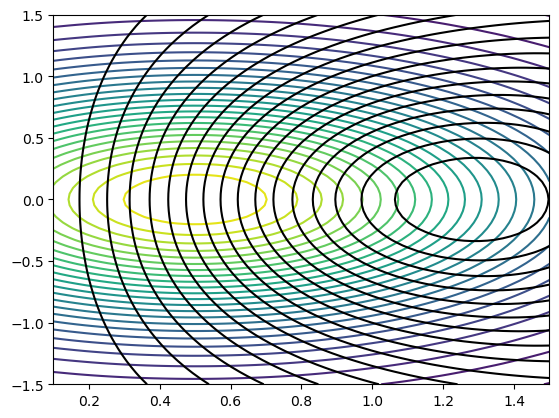

In [36]:
plt.contour(R, Z, J_tor, 30)  # Coloured lines are toroidal current
plt.contour(R, Z, psi, 20, colors='k')  # Black contours are poloidal flux

In a static plasma the current flows on flux surfaces (cross-field currents = torques). If we now try to update the solution, putting our toroidal current on flux surfaces, the plasma will have moved outwards!

**A toroidal current-carrying plasma will expand radially outwards**

This is seen in toroidal force balance as the **Hoop force** and **Tire force**. It appears in free-boundary Grad-Shafranov solvers as a systematic shift between iterations, since here we are not considering plasma inertia.


#### Radial force balance

The solution is to add a vertical magnetic field, providing an inward force. We can vary the current in the coil to find the coil current that keeps the plasma in (approximately) the initial location.

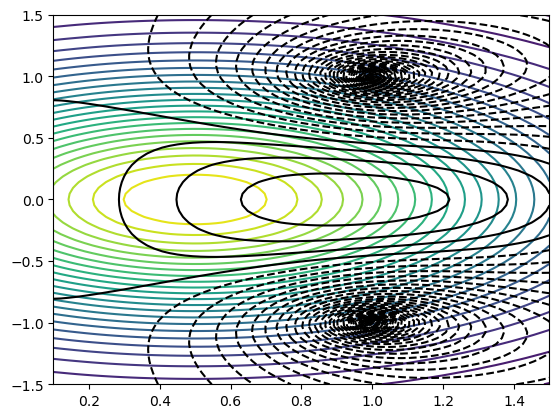

In [37]:
circuit_1 = Circuit([("P1L", Coil(1.0, -1.0), 1.0),
                    ("P1U", Coil(1.0, 1.0), 1.0)], # In series => Vertical field
                   current = -1e3) # 1kA in this circuit

# Add plasma and coil psi
total_psi = psi + circuit_1.psi(R, Z)

# Plot toroidal current and total psi
plt.contour(R, Z, J_tor, 30)  # Coloured lines are toroidal current
plt.contour(R, Z, total_psi, 40, colors='k')  # Black contours are poloidal flux

This is what the control system in a free-boundary Grad-Shafranov solver does!

Given a set of coils:
- The user may fix some currents
- Constraints are provided by the user: Locations of X-points ($B_R = B_Z = 0$) and iso-flux i.e. two points with the same value of $\psi$
- An automatic control system tries to find combinations of coil currents that best match the constraints

This is typically an ill-posed problem, either too many constraints or too few. 
- Regularisation needed
- Typically also want to minimise coil currents

**Note**: The method used in FreeGS minimizes the *change* in coil current between iterations, not the coil current. The coil currents it finds **may not be a global optimum**: https://github.com/freegs-plasma/freegs/blob/master/freegs/control.py#L68
- Other control methods may be used in practice to find global optimum

### Setting up a machine

#### Example of setting up a machine

1. A definition of the locations of the poloidal field coils, and how they are wired together, for example connected in series to the same power supplies. This is specific to the machine.
2. Plasma profiles of pressure and current, p(psi) and f(psi), together with global contraints such as total plasma current, which indirectly specify the size of the plasma.
3. A control system which sets the shape and location of the plasma. Like a real plasma, feedback control is needed to stabilise vertical and radial motion in free-boundary Grad-Shafranov solvers.

In [12]:
# Step 1: Specify the locations of the coils, and the domain you want to solve over

from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.TCV()


# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.1, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=65, ny=65)        # Number of grid points

In [13]:
# Step 2: Specify the profiles of pressure and f=R*Bt. 
# Currently quite simple functions are supported

from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(eq,  # Equilibrium
                            3e3, # Plasma pressure on axis [Pascals]
                            7e5, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [14]:
# Step 3: Specify the control system and feedback variables.
# The control system adjusts the currents in the poloidal field coils
# to produce X-points in the desired locations, and ensure that the desired
# pairs of locations have the same poloidal flux.

from freegs import control

xpoints = [(0.7, -1.1),   # (R,Z) locations of X-points
           (0.7, 1.1)]

# Contstrain these pairs of (R,Z, R,Z) locations to have the same poloidal flux
# This is needed for radial and vertical position control of the plasma.
isoflux = [(0.7,-1.1, 1.45, 0.0)   # Lower X-point, Outboard midplane
           ,(0.7,1.1, 1.45, 0.0)   # Upper X-point, Outboard midplane
          ]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

In [15]:
# With these three components (coils, profiles and constraints), solve the nonlinear
# system with a Picard iteration. This modifies the "eq" object.

from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

In [16]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 7.000000e+05 Amps


In [17]:
tokamak.printCurrents()

E1 : Coil(R=0.505, Z=-0.7, current=-79596.7, turns=1, control=True)
E2 : Coil(R=0.505, Z=-0.5, current=-45953.5, turns=1, control=True)
E3 : Coil(R=0.505, Z=-0.3, current=-28372.7, turns=1, control=True)
E4 : Coil(R=0.505, Z=-0.1, current=-26133.2, turns=1, control=True)
E5 : Coil(R=0.505, Z=0.1, current=-21316.3, turns=1, control=True)
E6 : Coil(R=0.505, Z=0.3, current=-30643.1, turns=1, control=True)
E7 : Coil(R=0.505, Z=0.5, current=-45513.5, turns=1, control=True)
E8 : Coil(R=0.505, Z=0.7, current=-79449.6, turns=1, control=True)
F1 : Coil(R=1.3095, Z=-0.77, current=-14772.5, turns=1, control=True)
F2 : Coil(R=1.3095, Z=-0.61, current=-30292.7, turns=1, control=True)
F3 : Coil(R=1.3095, Z=-0.31, current=-45706.1, turns=1, control=True)
F4 : Coil(R=1.3095, Z=-0.15, current=-53249.1, turns=1, control=True)
F5 : Coil(R=1.3095, Z=0.15, current=-53366.7, turns=1, control=True)
F6 : Coil(R=1.3095, Z=0.31, current=-45774.3, turns=1, control=True)
F7 : Coil(R=1.3095, Z=0.61, current=-30606

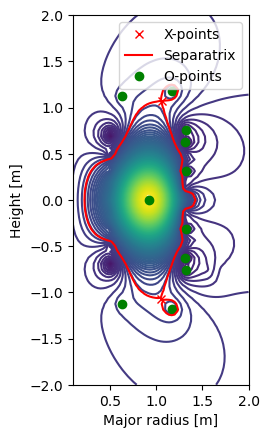

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [18]:
from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)

#### Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quite quickly finds a new solution.

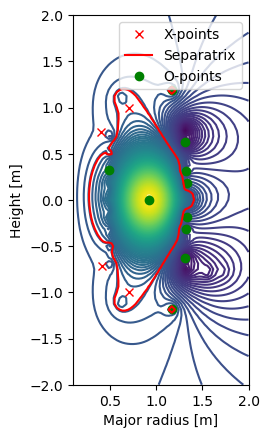

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [19]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)

In [20]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

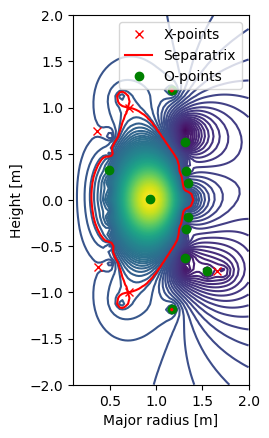

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [21]:
plotEquilibrium(eq)

## Pytorch Reinforced Learning

In [4]:
%pip install torch gym numpy matplotlib -q


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print(torch.__version__)  # Should display the installed version
print(torch.cuda.is_available())  # Should return False on macOS


2.5.1
False


### Define Environment

In [8]:
import gym
from gym import spaces
import numpy as np

class TokamakEnv(gym.Env):
    def __init__(self, n_coils, state_dim, initial_state, target_state):
        super().__init__()
        self.n_coils = n_coils
        self.state_dim = state_dim
        self.initial_state = initial_state
        self.target_state = target_state
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(n_coils,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_dim,))
        self.state = self.reset()
    
    def step(self, action):
        # Example: Call FreeGS with the action (coil currents/voltages)
        next_state = self.run_freegs(action)
        reward = self.calculate_reward(next_state)
        done = False  # Define a termination condition
        return next_state, reward, done, {}
    
    def reset(self):
        # Reset FreeGS simulation to a default state
        self.state = self.initial_state  # Replace with actual reset logic
        return self.state
    
    def run_freegs(self, action):
        # Interface with FreeGS (CLI/API calls) to get next state
        next_state = ...  # Parse FreeGS output
        return next_state

    def calculate_reward(self, state):
        # Define a reward based on proximity to desired plasma parameters
        reward = -np.linalg.norm(state - self.target_state)
        return reward


### Create DQN Network

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


### Implement Training Loop

In [7]:
import random
from collections import deque

# Hyperparameters
learning_rate = 1e-3
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.1
batch_size = 64
memory_size = 10000

# Initialize components
state_dim = ...  # Define state dimension
action_dim = ...  # Define action dimension
env = TokamakEnv()
model = DQN(state_dim, action_dim)
target_model = DQN(state_dim, action_dim)
target_model.load_state_dict(model.state_dict())  # Sync target network
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Replay buffer function
def replay():
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Compute Q-values
    q_values = model(states).gather(1, actions)
    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + (1 - dones) * gamma * next_q_values

    loss = nn.MSELoss()(q_values.squeeze(), target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
episodes = 500
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        # Select action (epsilon-greedy)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = model(torch.tensor(state, dtype=torch.float32)).argmax().item()
        
        # Step in the environment
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Store in replay buffer
        memory.append((state, action, reward, next_state, done))
        state = next_state

        # Train the model
        replay()

    # Update target network
    if episode % 10 == 0:
        target_model.load_state_dict(model.state_dict())
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print(f"Episode {episode}, Total Reward: {total_reward}")


NameError: name 'n_coils' is not defined

### Test the RL Model (Collapse this and look below for latest code)

In [ ]:
state = env.reset()
done = False
while not done:
    with torch.no_grad():
        action = model(torch.tensor(state, dtype=torch.float32)).argmax().item()
    state, reward, done, _ = env.step(action)
    print(f"State: {state}, Reward: {reward}")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from freegs import Plasma

# Define tokamak geometry and plasma parameters
tokamak_params = {
    'major_radius': 6.0,  # Major radius (m)
    'minor_radius': 2.0,  # Minor radius (m)
    'magnetic_field': 3.5,  # Magnetic field (T)
    'plasma_current': 15e6,  # Plasma current (A)
    'density': 1.0e19,  # Plasma density (m^-3)
    'temperature': 1.0e6,  # Plasma temperature (eV)
}

# Initialize plasma object
plasma = Plasma(major_radius=tokamak_params['major_radius'],
                minor_radius=tokamak_params['minor_radius'],
                magnetic_field=tokamak_params['magnetic_field'],
                plasma_current=tokamak_params['plasma_current'])

# Set density and temperature
plasma.set_density(tokamak_params['density'])
plasma.set_temperature(tokamak_params['temperature'])

# Optionally, you can set more parameters, like equilibrium profiles, transport coefficients, etc.
# For example:
# plasma.set_equilibrium_profile(...) # This depends on the specific FreeGS setup

# Run the simulation
# Depending on your setup, FreeGS may require initializing a solver or model:
plasma.run_simulation()

# Collect results from the simulation
results = plasma.get_results()  # Assuming the method returns simulation data

# Visualize results
plt.plot(results['time'], results['density_profile'])
plt.xlabel('Time (s)')
plt.ylabel('Density Profile (m^-3)')
plt.title('Plasma Density Profile Over Time')
plt.show()


ImportError: cannot import name 'Plasma' from 'freegs' (/Users/psonu/miniconda3/envs/fusion-env/lib/python3.12/site-packages/freegs/__init__.py)

In [55]:
import gym
from gym import spaces
import numpy as np

class TokamakEnv(gym.Env):
    def __init__(self, target_current, target_position):
        super(TokamakEnv, self).__init__()
        self.tokamak = machine.TCV()
        self.eq = Equilibrium(self.tokamak, Rmin=0.1, Rmax=2.0, Zmin=-2.0, Zmax=2.0, nx=65, ny=65)
        self.target_current = target_current
        self.target_position = target_position

        # Action space: Adjust currents in poloidal field coils
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(len(self.tokamak.coils),), dtype=np.float32)
        
        # Observation space: Plasma parameters (e.g., current, radial, vertical)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
        
    def reset(self):
        # Reset to initial conditions
        self.eq = Equilibrium(self.tokamak, Rmin=0.1, Rmax=2.0, Zmin=-2.0, Zmax=2.0, nx=1+2**5, ny=1+2**5)
        return self._get_obs()
    
    def step(self, action):
        # Apply action (adjust coil currents)
        for (name, coil), current in zip(self.tokamak.coils, action):
            if hasattr(coil, "setCurrent"):  # Ensure the object has setCurrent method
                coil.setCurrent(current)
            elif hasattr(coil, "current"):  # For cases like 'Circuit'
                coil.current = current
            else:
                raise AttributeError(f"Cannot set current for coil '{name}'.")

        # Solve for equilibrium with constraints
        profiles = ConstrainPaxisIp(self.eq, 3e3, 7e5, 0.4)
        
        # Define constraints (update these to suit your specific goals)
        xpoints = [(0.7, -1.1), (0.7, 1.1)]  # Example X-points
        isoflux = [(0.7, -1.1, 1.45, 0.0), (0.7, 1.1, 1.45, 0.0)]  # Example isoflux constraints
        constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)
        
        picard.solve(self.eq, profiles, constrain)

        # Calculate reward and check if done
        current_error = abs(self.eq.plasmaCurrent() - self.target_current)
        position_error = np.linalg.norm([0.7 - self.target_position[0], -1.1 - self.target_position[1]])
        reward = - (current_error + position_error)
        done = current_error < 1e-3 and position_error < 1e-2

        return self._get_obs(), reward, done, {}


    
    def _get_obs(self):
        return np.array([self.eq.plasmaCurrent(), 0.7, -1.1])  # Replace with actual state values


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the environment
env = make_vec_env(lambda: TokamakEnv(target_current=7e5, target_position=(0.7, -1.1)), n_envs=1)

# Define the RL model
model = PPO("MlpPolicy", env, policy_kwargs={'net_arch': [32]}, verbose=1, n_epochs=1, n_steps=2)


# Train the model
model.learn(total_timesteps=1)

# Save the model
model.save("tokamak_control_policy")


/Users/psonu/miniconda3/envs/fusion-env/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


ValueError: The environment is of type <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>, not a Gymnasium environment. In this case, we expect OpenAI Gym to be installed and the environment to be an OpenAI Gym environment.

In [60]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the environment with 4 parallel environments using threading
env = make_vec_env(lambda: TokamakEnv(target_current=7e5, target_position=(0.7, -1.1)), n_envs=4)

# Define the RL model with a simpler neural network and lower timesteps per update
model = PPO("MlpPolicy", env, policy_kwargs={'net_arch': [32]}, verbose=1, n_epochs=1, n_steps=2)

# Train the model with a reasonable number of timesteps
model.learn(total_timesteps=10)

# Save the trained model
model.save("tokamak_control_policy")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 8        |
---------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 1        |
|    ep_rew_mean          | 0        |
| time/                   |          |
|    fps                  | 1        |
|    iterations           | 2        |
|    time_elapsed         | 15       |
|    total_timesteps      | 16       |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -28.4    |
|    explained_variance   | nan      |
|    learning_rate        | 0.0003   |
|    loss          

In [61]:
env = TokamakEnv(target_current=7e5, target_position=(0.7, -1.1))
obs = env.reset()
done = False

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f"Obs: {obs}, Reward: {reward}")


Obs: [ 7.0e+05  7.0e-01 -1.1e+00], Reward: -3.4924596548080444e-10


## Latest Fusion code

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from freegs import machine
from freegs.equilibrium import Equilibrium
from freegs.coil import Coil
from freegs.machine import Circuit
from freegs.gradshafranov import GSsparse
from freegs.gradshafranov import Greens
from freegs.jtor import ConstrainPaxisIp
from freegs import control
from freegs import picard

# Assuming the required machine and equilibrium classes are defined elsewhere
# from your_model import machine, Equilibrium, control, picard, ConstrainPaxisIp

class TokamakEnv(gym.Env):
    def __init__(self, target_current, target_position):
        super(TokamakEnv, self).__init__()
        self.tokamak = machine.TCV()
        self.eq = Equilibrium(self.tokamak, Rmin=0.1, Rmax=2.0, Zmin=-2.0, Zmax=2.0, nx=65, ny=65)
        self.target_current = target_current
        self.target_position = target_position

        # Action space: Adjust currents in poloidal field coils
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(len(self.tokamak.coils),), dtype=np.float32)
        
        # Observation space: Plasma parameters (e.g., current, radial, vertical)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        # Reset to initial conditions
        self.eq = Equilibrium(self.tokamak, Rmin=0.1, Rmax=2.0, Zmin=-2.0, Zmax=2.0, nx=1+2**5, ny=1+2**5)
        return self._get_obs()
    
    def step(self, action):
        # Apply action (adjust coil currents)
        for (name, coil), current in zip(self.tokamak.coils, action):
            if hasattr(coil, "setCurrent"):  # Ensure the object has setCurrent method
                coil.setCurrent(current)
            elif hasattr(coil, "current"):  # For cases like 'Circuit'
                coil.current = current
            else:
                raise AttributeError(f"Cannot set current for coil '{name}'.")
            # print(f"name:{name}, coil:{coil}, current:{current}")

        # Solve for equilibrium with constraints
        profiles = ConstrainPaxisIp(self.eq, 3e3, self.target_current, 0.4)
        
        # Define constraints (update these to suit your specific goals)
        xpoints = [(0.7, -1.1), (0.7, 1.1)]  # Example X-points
        isoflux = [(0.7, -1.1, 1.45, 0.0), (0.7, 1.1, 1.45, 0.0)]  # Example isoflux constraints
        constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)
        
        picard.solve(self.eq, profiles, constrain)

        # Calculate reward and check if done
        current_error = abs(self.eq.plasmaCurrent() - self.target_current)
        position_error = np.linalg.norm([0.7 - self.target_position[0], -1.1 - self.target_position[1]])
        reward = - (current_error + position_error)
        done = current_error < 1e-3 and position_error < 1e-2

        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return np.array([self.eq.plasmaCurrent(), 0.7, -1.1])  # Replace with actual state values
        

target_current = 10e5  # Target plasma current (700,000 Amps)
target_position = (0.7, -1.1)  # Target radial, vertical position (meters)

# Create the environment with 4 parallel environments using threading
env = make_vec_env(lambda: TokamakEnv(target_current=target_current, target_position=target_position), n_envs=4)

# Define the RL model with a simpler neural network and lower timesteps per update
model = PPO("MlpPolicy", env, policy_kwargs={'net_arch': [32]}, verbose=1, n_epochs=1, n_steps=2)

# Train the model with a reasonable number of timesteps
model.learn(total_timesteps=10)  # Use a larger number of timesteps for real training

# Save the trained model
model.save("tokamak_control_policy")


# Now, test the model's performance after training

# # Specify the target values for the current and position
# target_current = 7e5  # Target plasma current (700,000 Amps)
# target_position = (0.7, -1.1)  # Target radial, vertical position (meters)

# Create the environment for testing
env = TokamakEnv(target_current=target_current, target_position=target_position)
obs = env.reset()
done = False

# Run the model to control the tokamak system
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f"Obs: {obs}, Reward: {reward}")

# Extract the final observed values
final_current = obs[0]  # Assuming the first value in `obs` is the plasma current
final_position = (obs[1], obs[2])  # Assuming the second and third values in `obs` are the radial and vertical positions

# Calculate errors in current and position
current_error = abs(final_current - target_current)
position_error = np.linalg.norm([final_position[0] - target_position[0], final_position[1] - target_position[1]])

# Display the final results and errors
print(f"Final current: {final_current} A")
print(f"Final position: {final_position} meters")
print(f"Target current: {target_current} A")
print(f"Target position: {target_position} meters")

print(f"Current error: {current_error}")
print(f"Position error: {position_error}")

# Check if the observed results are within acceptable tolerance
current_tolerance = 1e4  # Tolerance for current in Amps
position_tolerance = 1e-2  # Tolerance for position in meters

if current_error <= current_tolerance:
    print("Current is within the acceptable tolerance.")
else:
    print("Current is out of tolerance.")

if position_error <= position_tolerance:
    print("Position is within the acceptable tolerance.")
else:
    print("Position is out of tolerance.")


/Users/psonu/miniconda3/envs/fusion-env/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/Users/psonu/miniconda3/envs/fusion-env/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2 and n_envs=4)
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 0        |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8        |
---------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 1        |
|    ep_rew_mean          | 0        |
| time/                   |          |
|    fps                  | 0        |
|    iterations           | 2        |
|    time_elapsed         | 17       |
|    total_timesteps      | 16       |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -28.4    |
|    explained_variance   | nan      |
|    learning_rate        | 0.0003   |
|    loss                 | 0.0149  

In [72]:
len(eq.R) == len(eq.Z)

True

In [74]:
eq.R

array([[0.1      , 0.1      , 0.1      , ..., 0.1      , 0.1      ,
        0.1      ],
       [0.1296875, 0.1296875, 0.1296875, ..., 0.1296875, 0.1296875,
        0.1296875],
       [0.159375 , 0.159375 , 0.159375 , ..., 0.159375 , 0.159375 ,
        0.159375 ],
       ...,
       [1.940625 , 1.940625 , 1.940625 , ..., 1.940625 , 1.940625 ,
        1.940625 ],
       [1.9703125, 1.9703125, 1.9703125, ..., 1.9703125, 1.9703125,
        1.9703125],
       [2.       , 2.       , 2.       , ..., 2.       , 2.       ,
        2.       ]])

In [87]:
tokamak.coils[-1][-1]

Circuit([("OH1", Solenoid(Rs=0.43, Zsmin=-0.93, Zsmax=0.93, current=136.85052603721618, Ns=100, control=True), 0.01), ("C1", Coil(R=0.6215, Z=-1.11, current=13685.1, turns=1, control=True), 1.0), ("C2", Coil(R=0.6215, Z=1.11, current=13685.1, turns=1, control=True), 1.0), ("D1", Coil(R=1.1765, Z=-1.17, current=13685.1, turns=1, control=True), 1.0), ("D2", Coil(R=1.1765, Z=1.17, current=13685.1, turns=1, control=True), 1.0)], current=13685.052603721619, control=True)

In [100]:
!pip list

Package              Version
-------------------- -----------
absl-py              2.1.0
appnope              0.1.3
asttokens            2.0.5
cloudpickle          3.1.0
comm                 0.2.1
contourpy            1.2.0
cycler               0.11.0
debugpy              1.6.7
decorator            5.1.1
dm-env               1.6
dm-tree              0.1.8
executing            0.8.3
Farama-Notifications 0.0.4
filelock             3.16.1
fonttools            4.51.0
fortranformat        2.0.0
FreeGS               0.8.2
freeqdsk             0.5.0
fsspec               2024.10.0
gym                  0.26.2
gym-notices          0.0.8
gymnasium            1.0.0
h5py                 3.12.1
ipykernel            6.28.0
ipython              8.25.0
ipywidgets           8.1.5
jedi                 0.19.1
Jinja2               3.1.4
joblib               1.4.2
jupyter_client       8.6.0
jupyter_core         5.7.2
jupyterlab_widgets   3.0.13
kiwisolver           1.4.4
MarkupSafe           3.0.2
matplotli